# DAT405/DIT407 Introduction to Data Science and AI, SP4 22-23
## Assignment 3: Clustering

### Group 32: Saghar Alvandi, Sahar Abedi
### Hours spent on the task: Saghar 18h, Sahar 18h

In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


#loading dataset
df_raw = pd.read_csv('data_assignment3.csv')
df_raw.sample(5)

,residue name,position,chain,phi,psi
17583,ASN,193,B,-91.908605,114.929372
24072,ARG,252,J,-167.628228,105.147722
20165,VAL,143,A,-113.584168,12.179141
26492,ALA,124,A,-49.797630,-51.143808
11614,LEU,668,A,-135.645546,119.937029


In [222]:
# Drop rows with all NaN values
df = df_raw.dropna(how='all')

# Drop duplicate rows
df = df.drop_duplicates()

# Print the cleaned dataset
df.sample(5)


,residue name,position,chain,phi,psi
6882,THR,54,H,-157.295678,-174.966551
13844,THR,118,D,-65.214002,140.874201
28468,ILE,137,B,-67.815508,-42.275713
3051,GLN,173,A,-99.323085,176.019645
16057,GLU,381,I,60.653050,-23.311043


### 1) Show the distribution of phi and psi combinations using:
### a. A scatter plot

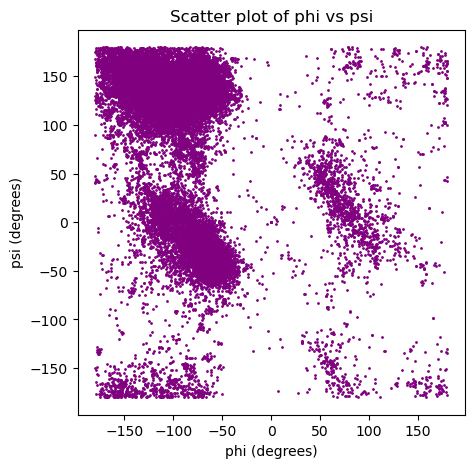

In [223]:
# Create a scatter plot 
plt.figure(figsize=(5,5))
plt.scatter(x=df['phi'], y=df['psi'], c='purple', s=1)

# Add axis labels and a title
plt.title('Scatter plot of phi vs psi')
plt.xlabel('phi (degrees)')
plt.ylabel('psi (degrees)')

# Show the plot
plt.show()


### b. A 2D histogram

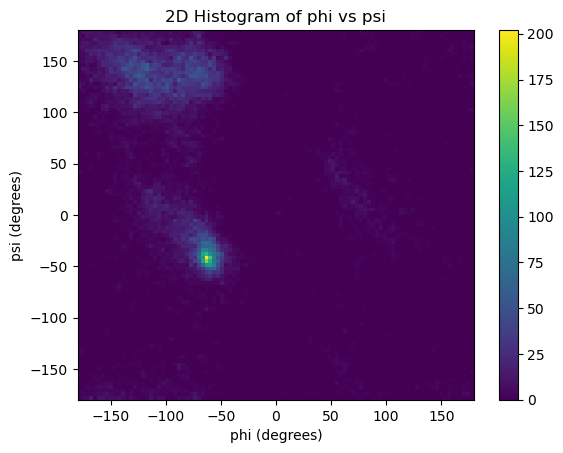

In [224]:
# Create a 2D histogram with 50 bins
plt.hist2d(x=df['phi'], y=df['psi'], bins=100)

# Add axis labels and a title
plt.xlabel('phi (degrees)')
plt.ylabel('psi (degrees)')
plt.title('2D Histogram of phi vs psi')

# Show the plot
plt.colorbar()
plt.show()

### c. The top edge of a Ramachandran plot wraps round to the bottom edge, and the right edge wraps around to the left edge (we can think of the 2D Ramachandran plot being mapped onto the surface of a torus). Ideally, this should be considered when clustering the data points on a Ramachandran plot. Can you transform the data, taking this into consideration, for better visualisation? Use your transformed data for questions 2-4.

Upon closer inspection of the scatterplot in 1a, it becomes apparent that there is a relatively clear separation between clusters at 0 degrees on the phi axis and -100 degrees on the psi axis. To highlight this separation, we can shift the origin of each axis to these points. This adjustment will make the cluster boundaries more obvious, allowing for easier visual identification and analysis.

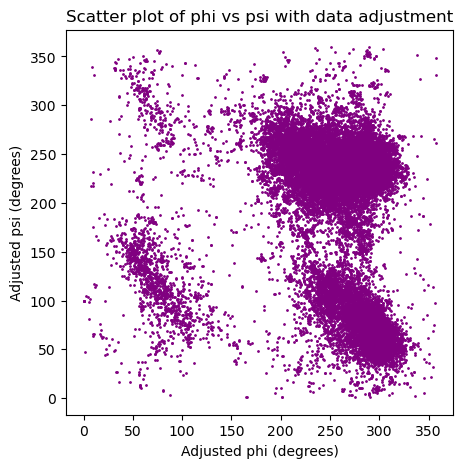

In [225]:
# Set adjustment values
phi_angle_adjustment = 360
psi_angle_adjustment = 100

# Adjust phi and psi columns by their respective values using lambda functions
df['phi adjusted'] = df.apply(lambda row: ((row.phi + phi_angle_adjustment) % 360), axis=1)
df['psi adjusted'] = df.apply(lambda row: ((row.psi + psi_angle_adjustment) % 360), axis=1)

# Plot the data
plt.figure(figsize=(5, 5))
# Set the color of the scatter plot to purple
plt.scatter(x=df['phi adjusted'], y=df['psi adjusted'], s=1, color='purple')
plt.xlabel('Adjusted phi (degrees)')
plt.ylabel('Adjusted psi (degrees)')
plt.title('Scatter plot of phi vs psi with data adjustment')
plt.show()


### 2)  Use the K-means clustering method to cluster the phi and psi angle combinations in the data file.
### a. Use an appropriate method to evaluate which value of K that gives the best clustering.

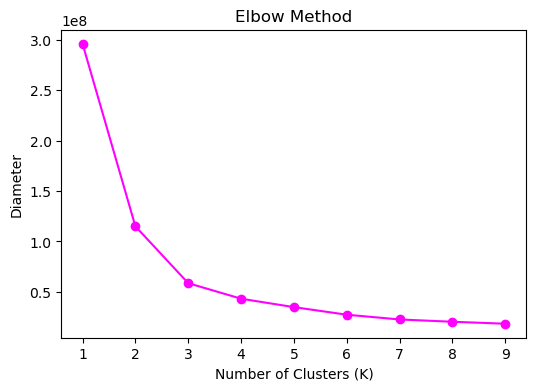

In [226]:
#Take out only coordinates
tempArray= df[["phi adjusted", "psi adjusted"]]

#Finding the best K-value with the help of elbow method
calculatedDistances = []
# Calculate distances
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(tempArray)
    calculatedDistances.append(kmeanModel.inertia_)

# Plot the elbow curve
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(K, calculatedDistances, color='magenta', marker='o')
plt.xticks(K)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Diameter')
plt.title('Elbow Method')
plt.show()



The elbow method is used to identify the optimal number of clusters. The optimal number of clusters is the value of K at the "elbow" of the curve, which is the point of inflection where the rate of decrease in diameter (longest distance between two points of the same color) starts to level off. This indicates that adding more clusters does not significantly decrease the diameter, and hence does not significantly improve the clustering. Based on the above plot, K=3 gives the best number of clustering, but to validate this value, we can also try K=2 and K=4 for clustering to compare the results.

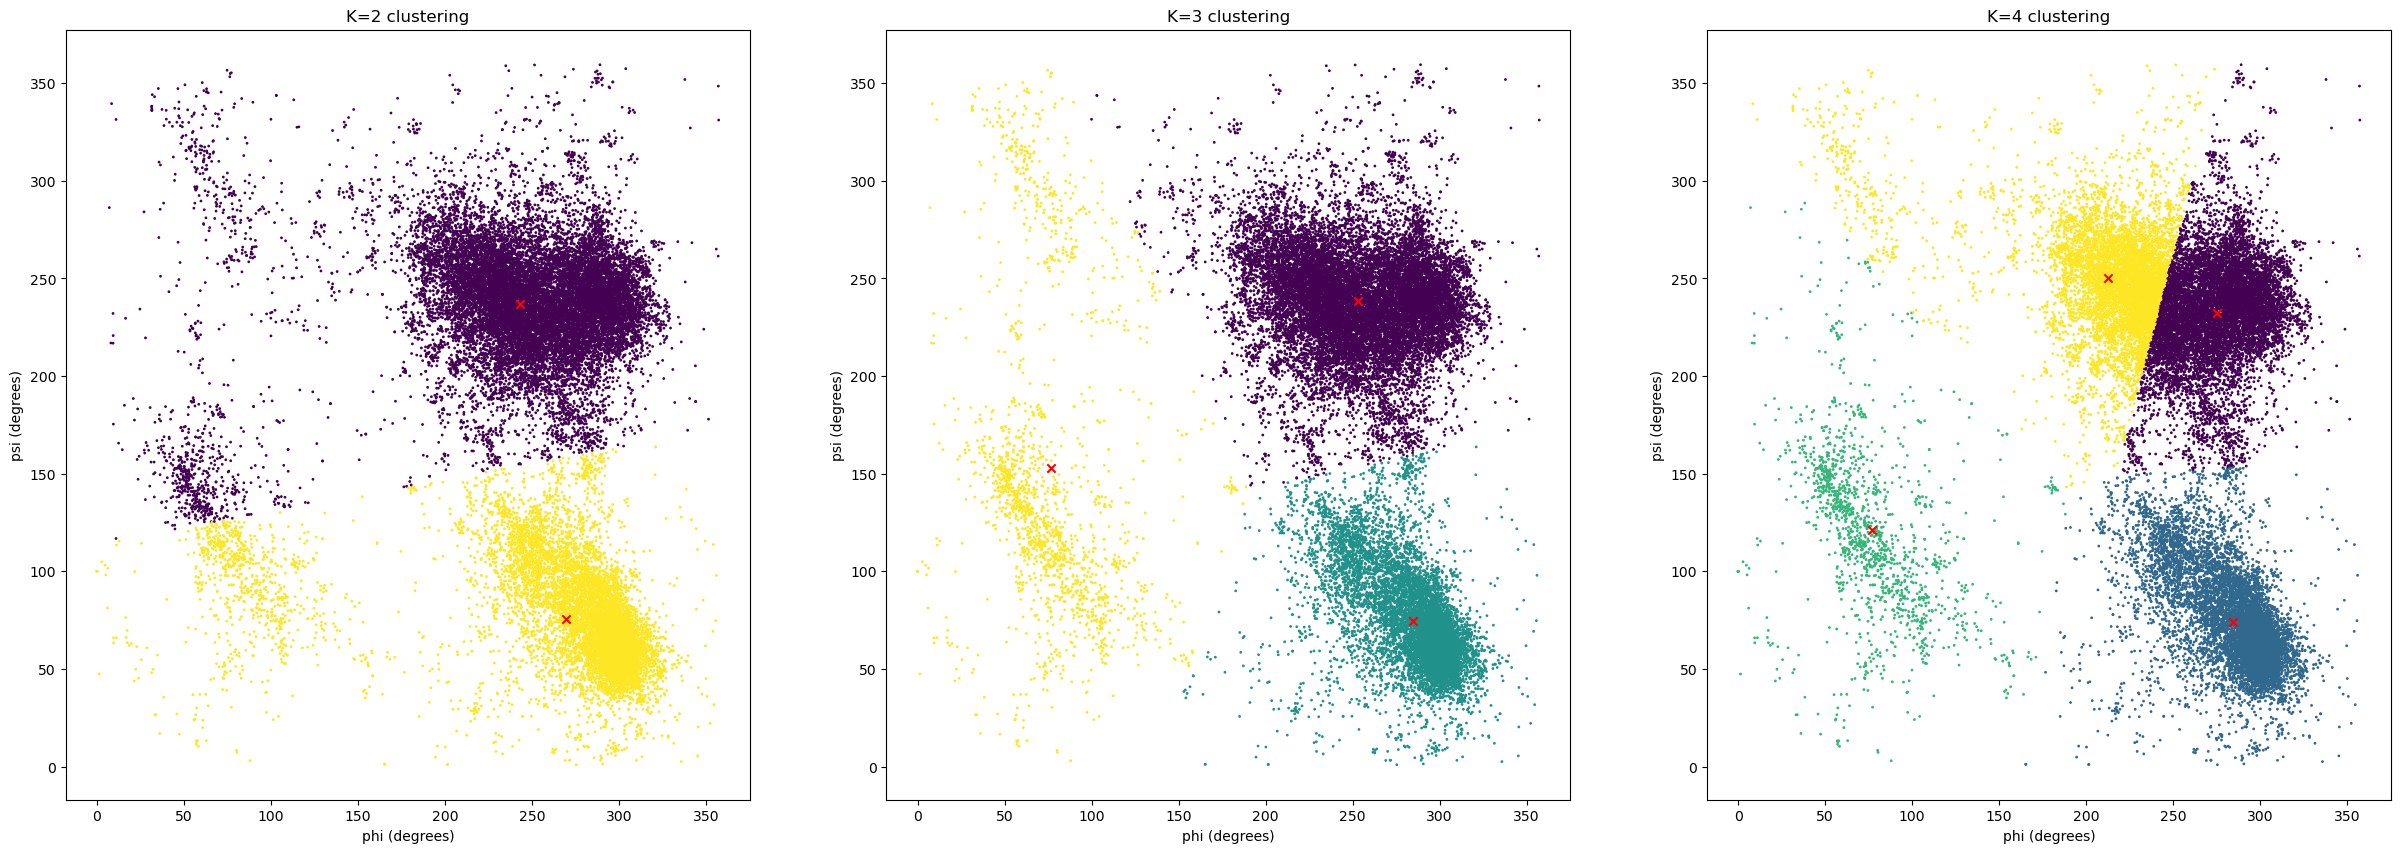

In [227]:
# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3)

# Perform K-Means clustering on the data using 2 clusters and fit the data
kmeans_2 = KMeans(n_clusters=2, n_init=10, random_state=0).fit(tempArray)

# Scatter plot the data with colors corresponding to their respective clusters
axs[0].scatter(tempArray["phi adjusted"], tempArray["psi adjusted"], s=1, c=kmeans_2.labels_.astype(float))

# Set the title and x/y labels for the subplot
axs[0].set_title('K=2 clustering')
axs[0].set(xlabel='phi (degrees)', ylabel='psi (degrees)')

# Scatter plot the centroids of the clusters with a red cross
axs[0].scatter(kmeans_2.cluster_centers_[:, 0], kmeans_2.cluster_centers_[:, 1], c='red', marker='x')

# Perform K-Means clustering on the data using 3 clusters and fit the data
kmeans_3 = KMeans(n_clusters=3, n_init=10, random_state=0).fit(tempArray)

# Scatter plot the data with colors corresponding to their respective clusters
axs[1].scatter(tempArray["phi adjusted"], tempArray["psi adjusted"], s=1, c=kmeans_3.labels_.astype(float))

# Set the title and x/y labels for the subplot
axs[1].set_title('K=3 clustering')
axs[1].set(xlabel='phi (degrees)', ylabel='psi (degrees)')

# Scatter plot the centroids of the clusters with a red cross
axs[1].scatter(kmeans_3.cluster_centers_[:, 0], kmeans_3.cluster_centers_[:, 1], c='red', marker='x')

# Perform K-Means clustering on the data using 4 clusters and fit the data
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=0).fit(tempArray)

# Scatter plot the data with colors corresponding to their respective clusters
axs[2].scatter(tempArray["phi adjusted"], tempArray["psi adjusted"], s=1, c=kmeans_4.labels_.astype(float))

# Set the title and x/y labels for the subplot
axs[2].set_title('K=4 clustering')
axs[2].set(xlabel='phi (degrees)', ylabel='psi (degrees)')

# Scatter plot the centroids of the clusters with a red cross
axs[2].scatter(kmeans_4.cluster_centers_[:, 0], kmeans_4.cluster_centers_[:, 1], c='red', marker='x')

# Set the size of the figure
fig.set_figwidth(30)
fig.set_figheight(10)


Based on the observations, we can conclude that k=3 seems to be the best clustering. The subplots for k=3 show a good separation between the clusters, and the cluster centers are positioned in the center of their respective clusters. Additionally, there are no overlapping points, and the data points are well-distributed within their respective clusters.

### b. Do the clusters found in part (a) seem reasonable?

Based on the scatter plot generated from the K-means clustering, the clusters found seem reasonable as there are some clear and distinct groupings that we can identify visually. However, there is still a lot of noise, where there seems to be some overlap between the clusters. It is possible that there are more clusters present in the data that are not captured by the K-means algorithm, or that the algorithm has split some clusters incorrectly.Therefore, it is reasonable to assume that there may be more clusters in the data, such as in the bottom right and left top corners, that were not picked up by the K-means clustering algorithm. However, it is important to note that the number of clusters chosen for the analysis may affect the results, and additional analysis could be done to test for robustness to cluster number choice.

### 3. Use the DBSCAN method to cluster the phi and psi angle combinations in the data file.
#### a. Motivate the choice of:
##### i. the minimum number of samples in the neighbourhood for a point to be considered as a core point, and
##### ii. the maximum distance between two samples belonging to the same neighbourhood (“eps” or “epsilon”).
#### b. Plot the clusters found using DBSCAN and any outliers in a scatter plot.

Number of clusters: 3


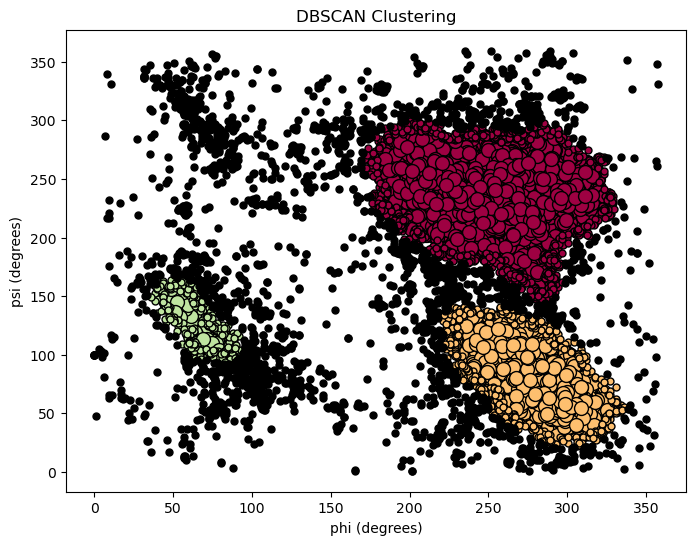

In [228]:
# Initializing figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('DBSCAN Clustering')
ax.set(xlabel='phi (degrees)', ylabel='psi (degrees)')

# Compute DBSCAN
db = DBSCAN(eps=10, min_samples=100).fit(tempArray)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    # Core points
    core = tempArray[class_member_mask & core_samples_mask]
    ax.plot(core["phi adjusted"], core["psi adjusted"], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
    
    # Noise and border points
    noiseANDborder = tempArray[class_member_mask & ~core_samples_mask]
    
    # Store outliers in a dataframe 
    if k == -1:
        outliers = tempArray[class_member_mask & ~core_samples_mask]
    ax.plot(noiseANDborder["phi adjusted"], noiseANDborder["psi adjusted"], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

print('Number of clusters: '+str(n_clusters_))
    

i. The minimum number of samples in the neighborhood for a point to be considered as a core point depends on the density of the data. If the data is dense, then a higher value of minimum samples can be chosen, and if the data is sparse, then a lower value can be chosen. A higher value of minimum samples will result in fewer clusters and more noise points, whereas a lower value of minimum samples will result in more clusters and fewer noise points. In the given code, the value of the minimum samples is 90, which is suitable for the given dataset. The value for min_samples (100) was generated by trial and error through manual testing with different values.

ii. The maximum distance between two samples belonging to the same neighborhood (epsilon) determines the maximum distance up to which two points are considered neighbors. If the epsilon is too small, then many points may be left out in the clusters, resulting in too many clusters or too many noise points. On the other hand, if the epsilon is too large, then points from different clusters may also be included in the same cluster, resulting in fewer clusters. In the given code, the value of epsilon is 10, which is suitable for the given dataset (testing again by trial and error). However, the optimal value of epsilon also can be found using different techniques such as the elbow method or silhouette analysis. 
Below, we have used the elbow method to obtain the optimal value for epsilon. Based on the results it seems that the elbow is on eps=10, which is compatible with the trial and error results.

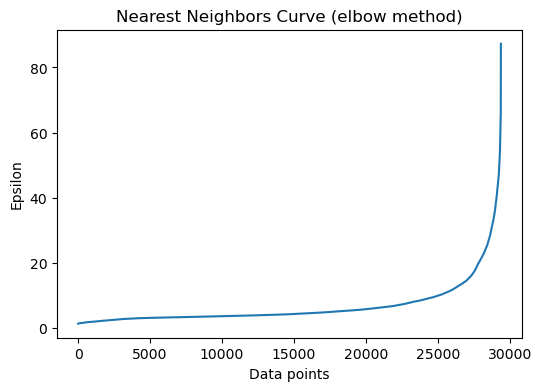

In [229]:
# Initializing figure
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Nearest Neighbors Curve (elbow method)')
ax.set(xlabel='Data points', ylabel='Epsilon')

#Fit nearest neighbour model
n_neighbors = 101
neigh = NearestNeighbors(n_neighbors=n_neighbors)
nbrs = neigh.fit(tempArray)

# Calculate distances to nearest neighbours
distances, indices = nbrs.kneighbors(tempArray)

# Sort distances in ascending order
sorted_distances = np.sort(distances, axis=0)

# Plot the distance to the 100th nearest neighbour for each data point
ax.plot(sorted_distances[:, n_neighbors-1])

# Show the plot
plt.show()

### c. How many outliers are found? Plot a bar chart to show how often each of the different amino acid residue types are outliers.

Number of outliers: 2604


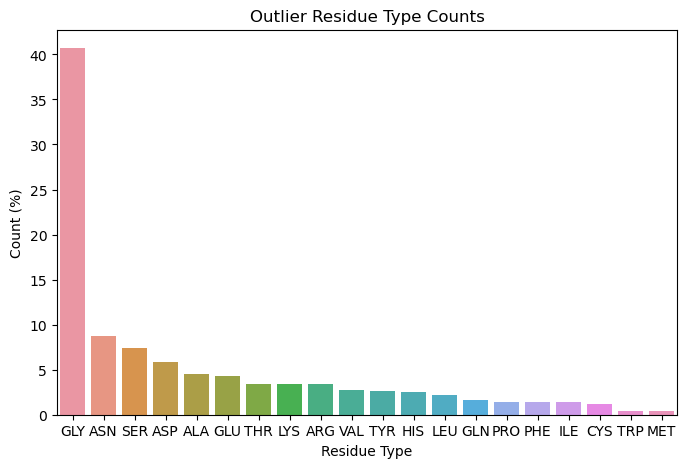

In [230]:
# Get the labels assigned by DBSCAN
labels = db.labels_

# Count the number of outliers
n_outliers = np.sum(labels == -1)
print("Number of outliers:", n_outliers)


# Count the frequency of each residue type among the outliers
outliers = df.iloc[labels == -1, :]
outlier_counts = outliers['residue name'].value_counts(normalize=True) * 100

# Plot the bar chart of outlier counts
plt.figure(figsize=(8,5))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.xlabel('Residue Type')
plt.ylabel('Count (%)')
plt.title('Outlier Residue Type Counts')
plt.show()


### d. Compare the clusters found by DBSCAN with those found using K-means. What are the pros and cons comparing DBSCAN and K-means for clustering?

In comparing DBSCAN and K-means clustering, we can see that both algorithms produce three clusters in a dataset. However, the clustering results are different: the K-means algorithm creates clusters of approximately equal size, while DBSCAN generates clusters with varying sizes. Additionally, DBSCAN can identify and separate outliers from the main clusters, while K-means include outliers in the clusters.

DBSCAN is a clustering algorithm that is robust to noise and can handle clusters of arbitrary shapes. It does not require the number of clusters to be specified in advance, and it can discover clusters with different densities. However, it can be sensitive to the choice of eps and may have difficulty identifying clusters with different densities in the same dataset. Also, it can be computationally expensive for large datasets.

K-means is a relatively fast and efficient clustering algorithm that is suitable for large datasets. However, it better works with clusters that are spherical and equally sized and also requires the number of clusters to be specified in advance. This makes it less suitable for datasets with irregular shapes or different cluster densities.




### 4) The data file can be stratified by amino acid residue type. Use DBSCAN to cluster the data that have residue type PRO. Investigate how the clusters found for amino acid residues of type PRO differ from the general clusters (i.e., the clusters that you get from DBSCAN with mixed residue types in question 3). What do you observe? Can you draw any conclusion with respect to question 3d? Note: The parameters might have to be adjusted from those used in question 3.

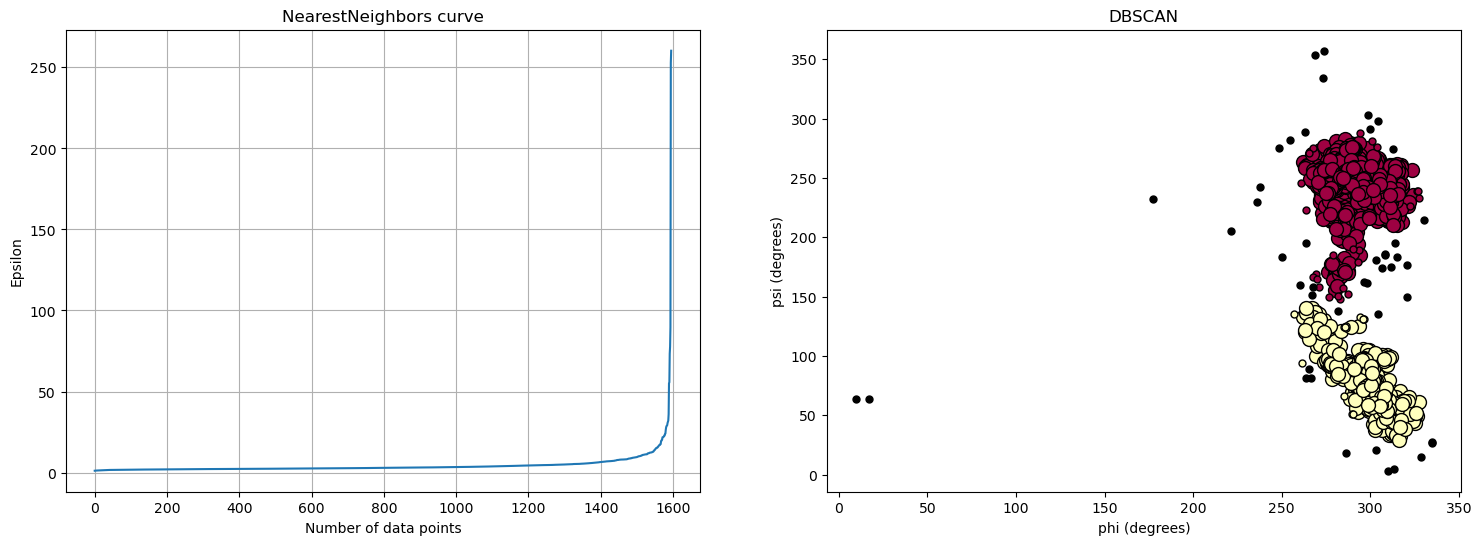

In [249]:
#Make a copy of original data
shifted_data = df.copy()

#Shift coordinates
shifted_data['phi']= shifted_data['phi'].mod(360)
shifted_data['psi']= (shifted_data['psi']+100).mod(360)

dataPRO = shifted_data.loc[shifted_data['residue name']=='PRO']

#Create figure and stack subplots next to each other
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

#Setting up the NearestNeighbors-method with n_neighbors=min_samples + 1
min_samples = 10
neigh = NearestNeighbors(n_neighbors=min_samples+1)
nbrs = neigh.fit(tempArray)
#Calculating distances 
distances, indices = nbrs.kneighbors(tempArray)
#Sorting distances in ascending order
distances = np.sort(distances, axis=0)

axs[0].plot(distances.transpose()[len(distances.transpose())-1])
axs[0].set_title('NearestNeighbors curve')
axs[0].set(xlabel = 'Number of data points', ylabel = 'Epsilon')
axs[0].grid('on')

# Compute DBSCAN
db = DBSCAN(eps=10, min_samples=min_samples).fit(tempArray)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Plot result
# Black removed and is used for noise instead
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    # Core points
    core = tempArray[class_member_mask & core_samples_mask]
    axs[1].plot(core["phi"], core["psi"], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
    
    # Noise and border points
    noiseANDborder = tempArray[class_member_mask & ~core_samples_mask]
    
    # Store outliers in a dataframe 
    if k == -1:
        outliers = tempArray[class_member_mask & ~core_samples_mask]
    axs[1].plot(noiseANDborder["phi"], noiseANDborder["psi"], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

axs[1].set_title('DBSCAN')
axs[1].set(xlabel = 'phi (degrees)', ylabel = 'psi (degrees)')

plt.show()


From the plot, it is evident that PRO data points tend to group towards a specific point on the plot, despite the existence of two clusters. When we compare this with the original data that contains all data points, we observe that there is a large cluster at the same location as the PRO data. This implies that the PRO data points do not differ significantly from the overall distribution. However, it is notable that the clustering is not uniform, as there are no three smaller clusters formed across the plot. 

This observation suggests that the choice of clustering algorithm may not have a significant impact on the results when the data points are relatively evenly distributed. However, when the data points are not uniformly distributed, different clustering algorithms may produce different results.
